# EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg' # plots look nicer in svg
%matplotlib inline
sns.set()
pd.options.display.max_colwidth = 160

## Load data

In [2]:
train = pd.read_csv('data/train.zip')
test  = pd.read_csv('data/test.zip')

In [3]:
display(train.shape, test.shape)

(19579, 3)

(8392, 2)

In [4]:
train.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set ...",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL


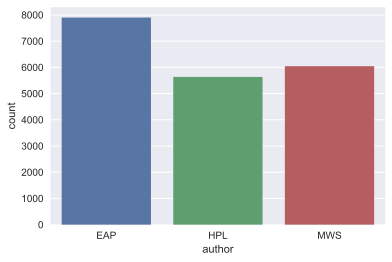

In [5]:
sns.countplot(x=train.author);

We see that classes are balanced

# Preprocessing

In [6]:
import spacy
import nltk

In [7]:
nlp = spacy.en.English()

In [8]:
# add custom stop words
spacy.en.STOP_WORDS.add("'s")
for word in spacy.en.STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

Define function to replace named entities in text

In [9]:
def replace_ents(doc):
    prefix = 'ent__'
    text = str(doc.doc)
    for ent in doc.ents:
        text = text.replace(ent.orth_, prefix + ent.label_)
    return text

Define func to preprocess text data. Here I am doing the following:
- Parsing text with spaCy
- Handcrafting new features identifying number of:
    - characters
    - words
    - punctuation characters
    - named entities
    - noun chunks
    - unique words
    - stop words
    - characters by word
- Replace named entities with tags like 'ent_ORG'
- Lemmatize
- Delete stopwords

I make 3 different versions of preprocessed text in order to try which fits best with CV.

In [10]:
def preprocess(df):
    print('Started parsing...')
    doc = df.text.apply(nlp)
    print('Text parsed')
    
    df['n_char']   = df.text.apply(len)
    df['n_words']  = doc.apply(lambda x: len([t for t in x if not t.is_punct]))
    df['n_punct']  = doc.apply(lambda x: len([t for t in x if t.is_punct]))
    df['n_ents']   = doc.apply(lambda x: len(x.ents))
    df['n_chunks'] = doc.apply(lambda x: len(list(x.noun_chunks)))
    df['n_unique_words'] = doc.apply(lambda x: len(set([t.lower_ for t in x if not t.is_punct])))
    df['n_stop_words']   = doc.apply(lambda x: len([t for t in x if t.is_stop]))
    df['char_by_word']   = doc.apply(lambda x: np.mean([len(t.orth_) for t in x if not t.is_punct]))
    print('Features created')
    
    df['text_ent_repl'] = doc.apply(replace_ents)
    print('Entities replaced')
    
    clean_and_lemmatize = lambda x: ' '.join([t.lemma_ for t in x if not t.is_punct and not t.is_stop])
    df['text_cleaned'] = doc.apply(clean_and_lemmatize)
    print('Text cleaned')

In [11]:
%%time
preprocess(train)

Started parsing...
Text parsed
Features created
Entities replaced
Text cleaned
CPU times: user 32.8 s, sys: 250 ms, total: 33.1 s
Wall time: 33.2 s


In [12]:
%%time
preprocess(test)

Started parsing...
Text parsed
Features created
Entities replaced
Text cleaned
CPU times: user 15 s, sys: 166 ms, total: 15.2 s
Wall time: 15.3 s


## Visulizations

Split train by authors to make distinct visualizations

In [13]:
eap = train.loc[train.author == 'EAP']
hpl = train.loc[train.author == 'HPL']
mws = train.loc[train.author == 'MWS']

eap_t = eap.text_cleaned
hpl_t = hpl.text_cleaned
mws_t = mws.text_cleaned

### Plot frequncies

In [14]:
fd = nltk.FreqDist([y for x in train.text_cleaned.str.split() for y in x])

fd_eap = nltk.FreqDist([y for x in eap_t.str.split() for y in x])
fd_hpl = nltk.FreqDist([y for x in hpl_t.str.split() for y in x])
fd_mws = nltk.FreqDist([y for x in mws_t.str.split() for y in x])

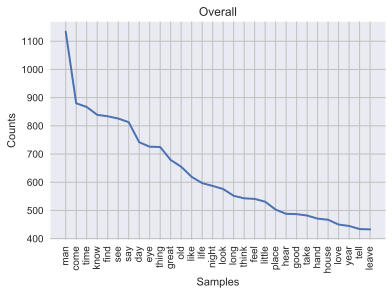

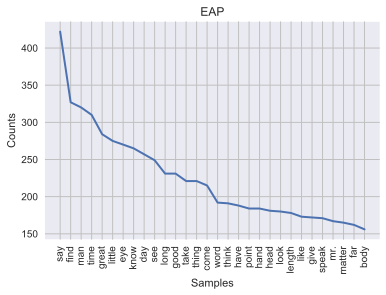

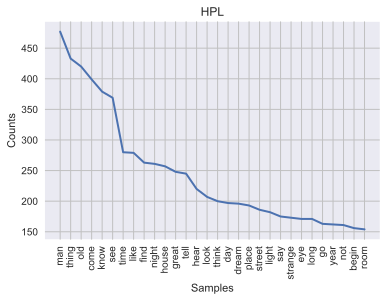

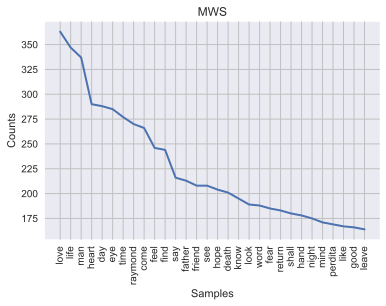

In [15]:
fd.plot(30, title='Overall')
fd_eap.plot(30, title='EAP')
fd_hpl.plot(30, title='HPL')
fd_mws.plot(30, title='MWS')

We see that top frequent words differ for the most part depending on the author, though they have some common words like 'man', 'see'.

### Word Clouds

In [16]:
from wordcloud import WordCloud
sns.set_style({'axes.grid' : False})

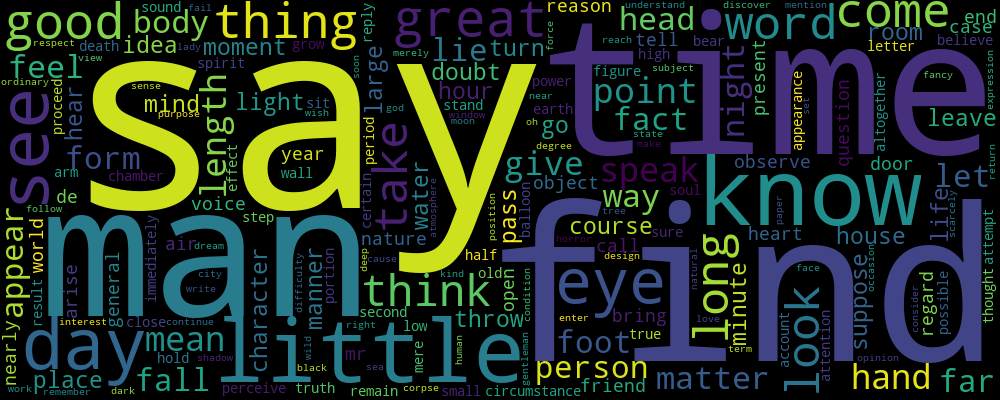

In [17]:
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(eap_t)).to_image()

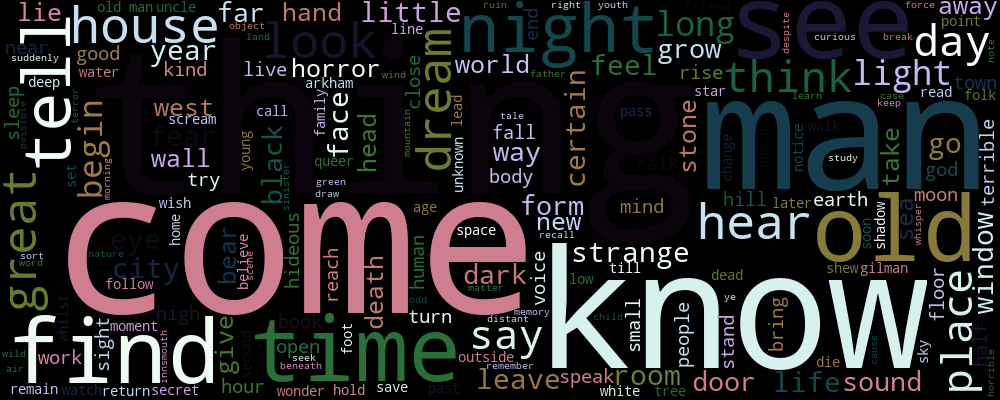

In [18]:
WordCloud(min_font_size=8, width=1000, height=400, colormap='cubehelix_r').generate(' '.join(hpl_t)).to_image()

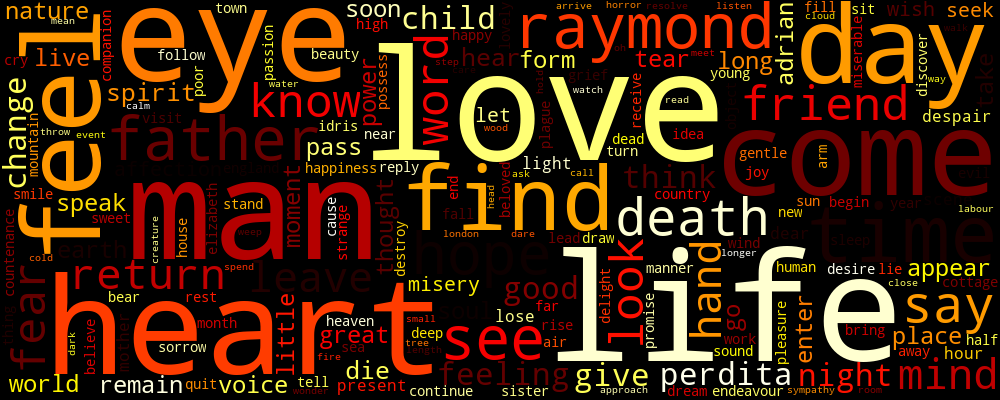

In [19]:
WordCloud(min_font_size=8, width=1000, height=400, colormap='hot').generate(' '.join(mws_t)).to_image()

### Meta-features distributions

In [20]:
sns.set()

In [21]:
def drop_outliers(s):
    med = s.mean()
    std = s.std()
    return s[(med - 3*std <= s) & (s <= med + 3*std)]

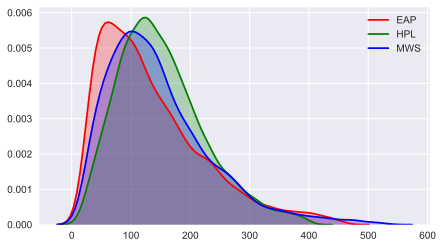

In [22]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.n_char), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.n_char), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.n_char), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);

We see that EAP's texts are a little bit shorter on average while HPL's are longer

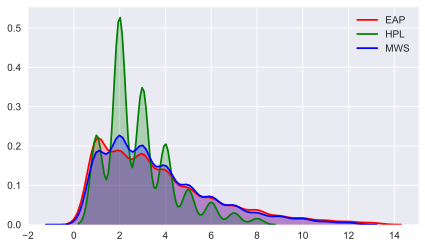

In [23]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.n_punct), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.n_punct), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.n_punct), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);

Here we see some difference in distribution between HPL and others

# Models

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

In [25]:
y = train.author

## Only text

### CountVect + untouched text

In [26]:
vectorizer = CountVectorizer(
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2), stop_words='english'
)
X = vectorizer.fit_transform(train.text)

In [27]:
%%time
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.502 +- 0.024
CPU times: user 256 ms, sys: 52.5 ms, total: 308 ms
Wall time: 6.1 s


In [28]:
%%time
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.443 +- 0.034
CPU times: user 214 ms, sys: 47.4 ms, total: 261 ms
Wall time: 725 ms


0.443 - Nice performance with just NB!

### CountVect + cleaned text

In [29]:
vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(train.text_cleaned)

In [30]:
%%time
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.500 +- 0.029
CPU times: user 264 ms, sys: 55.7 ms, total: 320 ms
Wall time: 6.48 s


In [31]:
%%time
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.457 +- 0.045
CPU times: user 217 ms, sys: 45.4 ms, total: 262 ms
Wall time: 823 ms


LR shows the same perf. while NB's is a little worse

### CountVect + replaced entities text

In [70]:
vectorizer = CountVectorizer(token_pattern=r'\w{1,}', stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(train.text_ent_repl)

In [71]:
%%time
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.559 +- 0.021
CPU times: user 241 ms, sys: 51.4 ms, total: 293 ms
Wall time: 8.42 s


In [72]:
%%time
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.532 +- 0.034
CPU times: user 237 ms, sys: 49.4 ms, total: 286 ms
Wall time: 830 ms


Seems like replacing named entities doesn't help

### TF-IDF + cleaned text

In [35]:
vectorizer = TfidfVectorizer(
    token_pattern=r'\w{1,}', ngram_range=(1, 1), 
    use_idf=True, smooth_idf=True, sublinear_tf=True,
)
X = vectorizer.fit_transform(train.text_cleaned)

In [36]:
%%time
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.610 +- 0.019
CPU times: user 170 ms, sys: 41.9 ms, total: 212 ms
Wall time: 1.02 s


In [37]:
%%time
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.585 +- 0.016
CPU times: user 162 ms, sys: 44.4 ms, total: 207 ms
Wall time: 513 ms


tfidf performs worse than simple count vect

## Only meta-features

In [62]:
import xgboost as xgb
import lightgbm as lgb

In [41]:
drop = ['id', 'text', 'text_cleaned', 'text_ent_repl']

In [42]:
X_meta = train.drop(drop + ['author'], axis=1)

In [43]:
%%time
lgbc = lgb.LGBMClassifier(objective='multiclass', n_estimators=100)
scores = cross_val_score(lgbc, X_meta, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.956 +- 0.008
CPU times: user 4.01 s, sys: 5.08 s, total: 9.08 s
Wall time: 5.4 s


In [44]:
%%time
xgbc = xgb.XGBClassifier(objective='multi:softprob', n_estimators=200)
scores = cross_val_score(xgbc, X_meta, y, cv=4, n_jobs=4, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.956 +- 0.007
CPU times: user 122 ms, sys: 32.5 ms, total: 154 ms
Wall time: 3.54 s


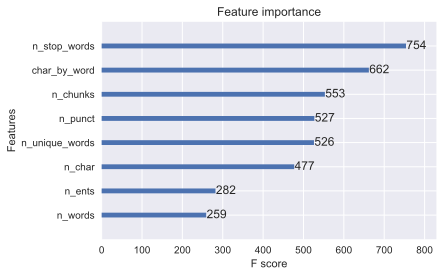

In [45]:
xgbc.fit(X_meta, y);
xgb.plot_importance(xgbc);

## Stack 'em

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [47]:
def add_prob_features(vectorizer, col, model, prefix, cv=5):
    vectorizer.fit(train[col].append(test[col]))
    X = vectorizer.transform(train[col])
    X_test = vectorizer.transform(test[col])
    
    cv_scores = []
    pred_test = 0
    pred_train = np.zeros([train.shape[0], 3])
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)
    
    print('CV started')
    for train_index, dev_index in kf.split(X, y):
        X_train, X_dev = X[train_index], X[dev_index]
        y_train, y_dev = y[train_index], y[dev_index]
        
        model.fit(X_train, y_train)
        pred_dev   = model.predict_proba(X_dev)
        pred_test += model.predict_proba(X_test)
    
        pred_train[dev_index, :] = pred_dev
        cv_scores.append(metrics.log_loss(y_dev, pred_dev))
        print('.', end='')
        
    print('')
    print("Mean CV LogLoss: %.3f" % (np.mean(cv_scores)))
    pred_test /= cv

    train[prefix+'eap'] = pred_train[:, 0]
    train[prefix+'hpl'] = pred_train[:, 1]
    train[prefix+'mws'] = pred_train[:, 2]
    
    test[prefix+'eap'] = pred_test[:, 0]
    test[prefix+'hpl'] = pred_test[:, 1]
    test[prefix+'mws'] = pred_test[:, 2]

In [48]:
vectorizer = CountVectorizer(
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2), stop_words='english'
)
add_prob_features(vectorizer, 'text', MultinomialNB(), 'nb_ctv_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.433


In [49]:
vectorizer = TfidfVectorizer(
    token_pattern=r'\w{1,}', ngram_range=(1, 1), 
    use_idf=True, smooth_idf=True, sublinear_tf=True,
)
add_prob_features(vectorizer, 'text_cleaned', MultinomialNB(), 'nb_tfv_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.577


In [50]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 5), analyzer='char'
)
add_prob_features(vectorizer, 'text', MultinomialNB(), 'nb_char_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.732


In [73]:
vectorizer = CountVectorizer(
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2), stop_words='english'
)
add_prob_features(vectorizer, 'text_ent_repl', MultinomialNB(), 'nb_ent_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.523


In [74]:
X = train.drop(drop + ['author'], axis=1)

In [86]:
%%time
lgbc = lgb.LGBMClassifier(objective='multiclass', n_estimators=150, num_leaves=10)
scores = cross_val_score(lgbc, X, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.344 +- 0.016
CPU times: user 5.36 s, sys: 2.5 s, total: 7.86 s
Wall time: 3.49 s


In [76]:
%%time
xgbc = xgb.XGBClassifier(objective='multi:softprob', n_estimators=150)
scores = cross_val_score(xgbc, X, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.344 +- 0.014
CPU times: user 14.3 s, sys: 30.7 ms, total: 14.3 s
Wall time: 14.4 s


In [77]:
%%time
xgbc.fit(X, y);

CPU times: user 4.77 s, sys: 19.3 ms, total: 4.79 s
Wall time: 4.81 s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

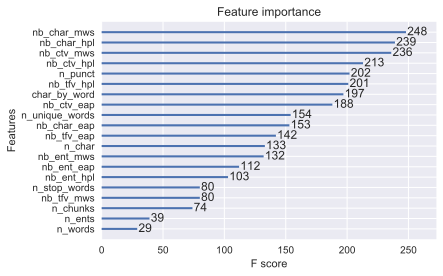

In [78]:
xgb.plot_importance(xgbc);

In [79]:
def sub(est, name='sub.csv'):
    sub = pd.DataFrame(est.predict_proba(test.drop(drop, axis=1)), columns=['EAP', 'HPL', 'MWS'])
    sub.insert(0, 'id', test.id)
    sub.to_csv(name, index=False)

In [80]:
from sklearn import model_selection

In [81]:
clf = xgb.XGBClassifier(objective = 'multi:softprob', nthread=1)

parameters = {
    'n_estimators': [150],
    'max_depth': [3],
    'subsample': [0.65],
    'colsample_bytree': [0.95],
    'min_child_weight': [1],
}

clf = model_selection.GridSearchCV(clf, parameters, n_jobs=4, verbose=1, scoring='neg_log_loss', refit=True)  

In [82]:
clf.fit(X, y);

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    5.2s finished


In [83]:
-clf.best_score_

0.34366016761336943

In [84]:
sub(clf.best_estimator_)